In [10]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "-1"

import torch
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from torch import nn
import torch.nn.functional as F

from causal_util import load_env
from causal_util.collect_data import EnvDataCollector
from matplotlib import pyplot as plt
from keychest.keychestenv import keychest_obs3d_to_obs2d, keychest_obs2d_to_image
from sparse_causal_model_learner_rl.sacred_gin_tune.sacred_wrapper import load_config_files
import pickle as pickle
from causal_util.helpers import one_hot_encode
import gin
import io

In [11]:
ckpt = '/home/serge/copy/main_fcn_d2096_00001_1_2020-12-25_14-31-05/checkpoint_106000/checkpoint'

In [12]:
# https://github.com/pytorch/pytorch/issues/16797
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [13]:
with open(ckpt, 'rb') as f:
    learner = CPU_Unpickler(f).load()#pickle.load(f)

Make environment KeyChest-v0 None {}


In [14]:
env = learner.env
h, w, c = env.engine._observation.shape

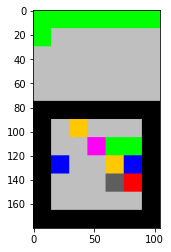

In [15]:
obs = env.reset()
obs = obs.reshape(h, w, c)
plt.imshow(keychest_obs2d_to_image(keychest_obs3d_to_obs2d(obs)))
plt.show()

In [16]:
learner.decoder(torch.tensor(np.random.randn(1, 924), dtype=torch.float32).to(learner.device))

tensor([[-0.0295, -0.0881, -0.0419, -0.0147, -0.0144,  0.0882, -0.1176,  0.0172,
          0.0498, -0.0617,  0.0459, -0.0410,  0.1154,  0.0435,  0.0633,  0.1359,
         -0.0464, -0.0386, -0.0563,  0.0599,  0.0985,  0.0585,  0.0544, -0.0804,
         -0.0539,  0.1698,  0.0849, -0.0558, -0.0458,  0.1026, -0.0257,  0.0389]],
       grad_fn=<AddmmBackward>)

In [17]:
learner.collect_steps()

In [18]:
from sparse_causal_model_learner_rl.loss.losses import fit_loss, reconstruction_loss_value_function_reward_to_go

In [19]:
fit_loss(**learner._context).item()

1.1554137927305419e-05

In [20]:
reconstruction_loss_value_function_reward_to_go(**learner._context).item()

0.057303838431835175

In [21]:
#for _ in range(100):
#    learner._epoch()

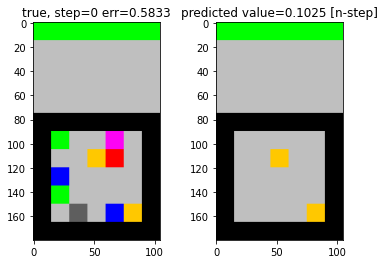

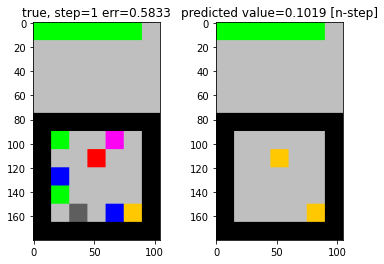

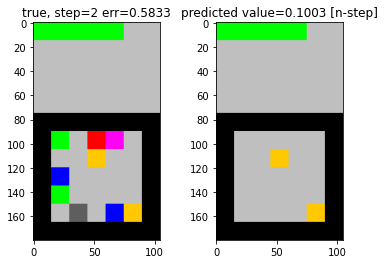

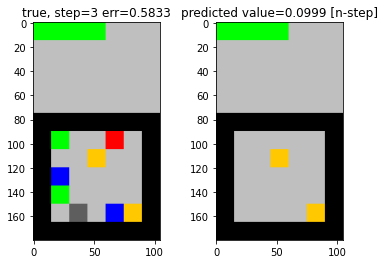

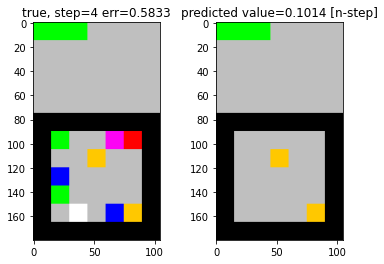

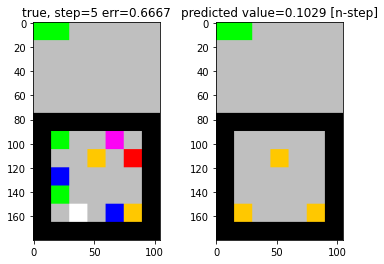

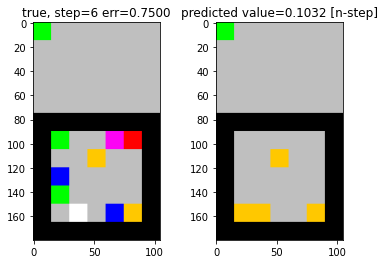

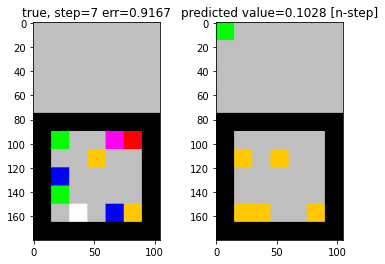

In [35]:
obs = env.reset()
obs_model = torch.tensor(obs).to(learner.device)
obs_models = []
errors = []

step = 0
while True:
    action = env.action_space.sample()
    act_one_hot = one_hot_encode(env.action_space.n, action)
    
    
    if hasattr(learner, 'model'):
        obs_model = learner.reconstructor(learner.model(
            learner.decoder(obs_model).unsqueeze(0), # previous model observation
            #torch.tensor(obs).to(learner.device).unsqueeze(0), # previous true observation
            torch.tensor(act_one_hot).to(learner.device).unsqueeze(0),
        ))[0]

        obs_model_show = obs_model.cpu().detach().numpy().reshape(h, w, c)
        obs_models.append(obs_model_show)
        obs_model_show = obs_model_show > 0.5
    
    if hasattr(learner, 'value_predictor'):
        value = learner.value_predictor(learner.decoder(torch.tensor(obs).to(learner.device).unsqueeze(0))).item()
    else:
        value = -1
    
    obs, rew, done, info = env.step(action)
    
    obs_show = obs.reshape(h, w, c)
    
    if hasattr(learner, 'model'):
        error = np.linalg.norm((obs_show - obs_model_show).flatten()) ** 2 / len(obs_show)
        errors.append(error)
    else:
        error = -1
    
    plt.subplot(1, 2, 1)
    plt.title("true, step=%d err=%.4f" % (step, error))
    plt.imshow(keychest_obs2d_to_image(keychest_obs3d_to_obs2d(obs_show)))
    plt.subplot(1, 2, 2)
    plt.title("predicted value=%.4f [n-step]" % value)
    if hasattr(learner, 'model'):
        plt.imshow(keychest_obs2d_to_image(keychest_obs3d_to_obs2d(obs_model_show)))
    plt.show()
    
    step += 1
    if done: break

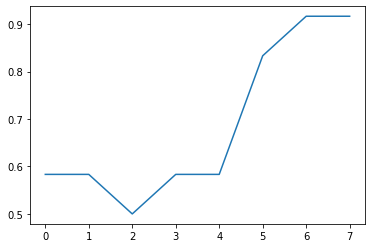

In [24]:
plt.plot(errors)

(array([3.00e+00, 8.00e+00, 5.30e+01, 6.36e+03, 4.52e+02, 5.90e+01,
        2.60e+01, 1.50e+01, 1.00e+01, 4.06e+02]),
 array([-0.6578852 , -0.47917765, -0.30047008, -0.12176254,  0.05694501,
         0.23565257,  0.4143601 ,  0.59306765,  0.77177525,  0.9504828 ,
         1.1291903 ], dtype=float32),
 <BarContainer object of 10 artists>)

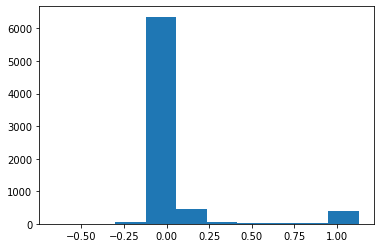

In [25]:
plt.hist([y for x in obs_models for y in x.flatten()])

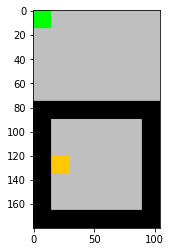

In [30]:
obs = obs_model.detach().numpy().reshape(h, w, c) > 0.5
plt.imshow(keychest_obs2d_to_image(keychest_obs3d_to_obs2d(obs)))
plt.show()

# Feature attribution

#### Distribution of latent variables

In [48]:
learner.collect_steps()

In [51]:
obs_x_batch = learner._context['obs_x']

In [54]:
obs_dec = learner.decoder(obs_x_batch).detach().cpu().numpy()

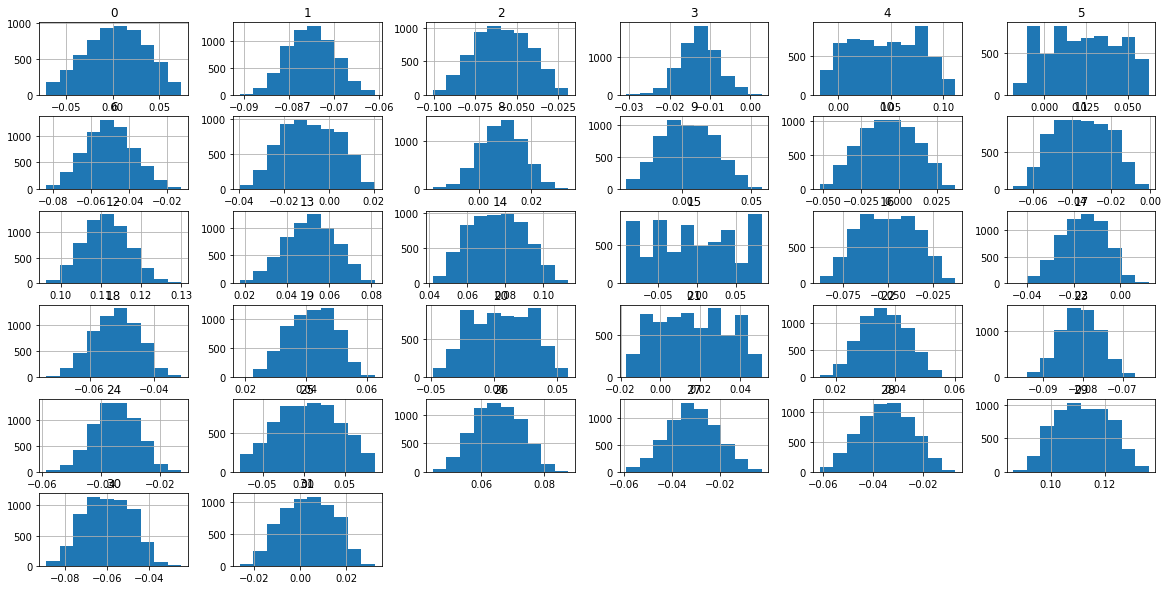

In [61]:
df = pd.DataFrame(obs_dec)
_ = df.hist(figsize=(20, 10))

#### ranges for latent variables

In [62]:
n_latent = obs_dec.shape[1]

In [71]:
latent_min_max = list(zip(np.min(obs_dec, axis=0), np.max(obs_dec, axis=0)))

### Taking one observation and going over latent variables

In [101]:
obs = env.reset()
obs_model = torch.tensor(obs).to(learner.device)

In [104]:
def vis_feature(obs_model, latent_idx=0, n_steps=10):
    """Visualize one feature."""
    lmin, lmax = latent_min_max[latent_idx]
    # decoded observation
    obs_dec = learner.decoder(obs_model).unsqueeze(0)

    print(f"Feature {latent_idx}, {n_steps} steps")
    plt.figure(figsize=(20, 5))
    for i, val in enumerate(np.linspace(lmin, lmax, n_steps)):
        plt.subplot(1, n_steps, i + 1)
        plt.title(f"f_{latent_idx}={round(val, 2)}")
        obs_dec[0, latent_idx] = torch.tensor(val)

        rgb_img = keychest_obs2d_to_image(keychest_obs3d_to_obs2d(learner.reconstructor(obs_dec).cpu().detach().numpy().reshape(h, w, c) > 0.5))
        plt.imshow(rgb_img)
    plt.show()

Feature 0, 10 steps


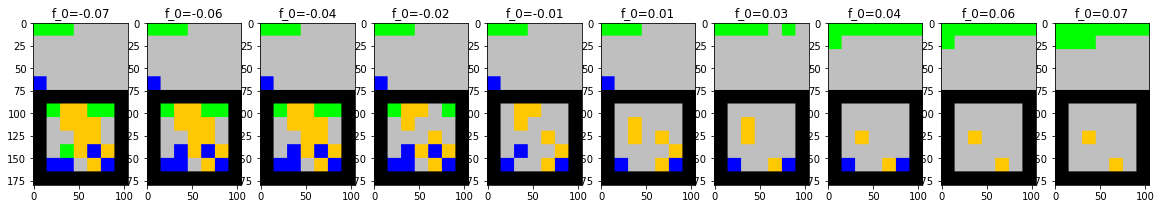

Feature 1, 10 steps


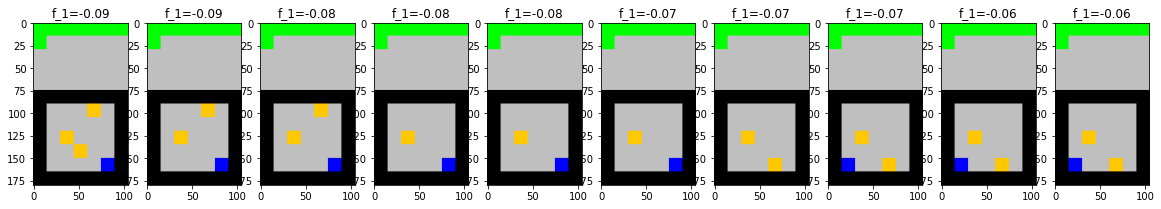

Feature 2, 10 steps


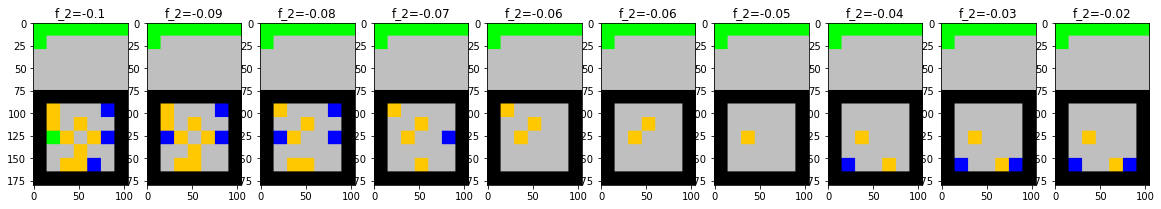

Feature 3, 10 steps


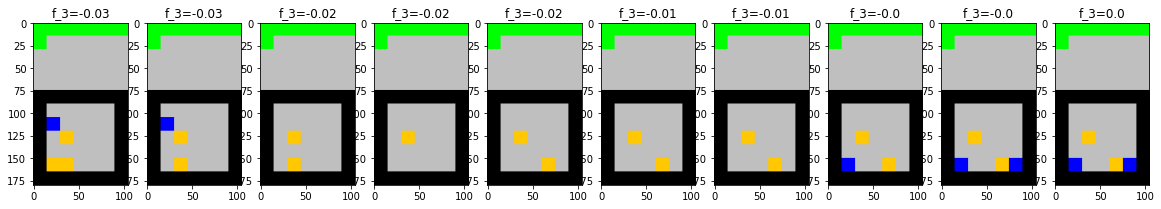

Feature 4, 10 steps


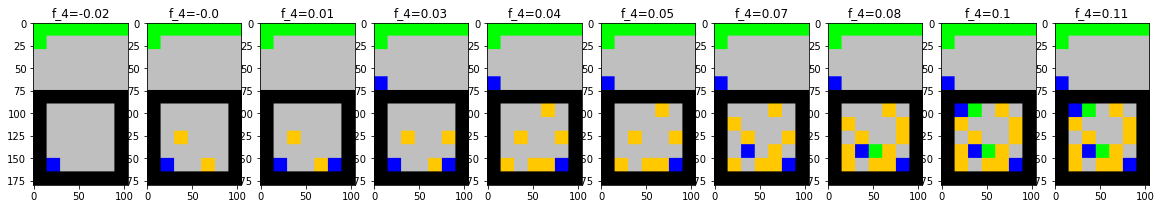

Feature 5, 10 steps


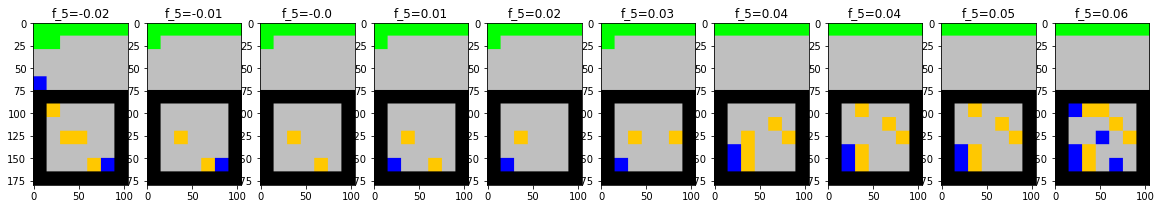

Feature 6, 10 steps


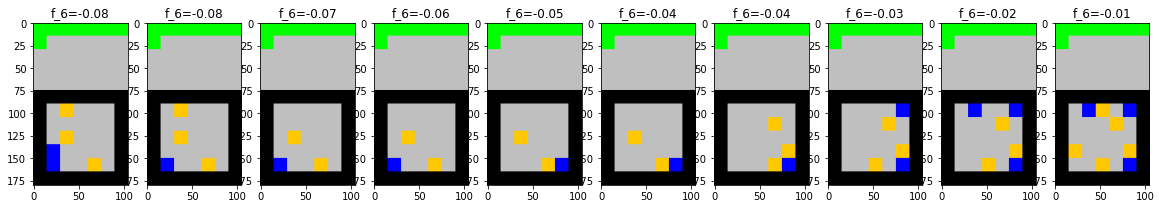

Feature 7, 10 steps


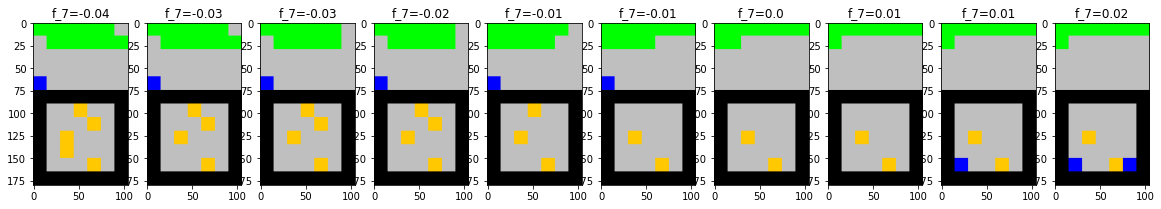

Feature 8, 10 steps


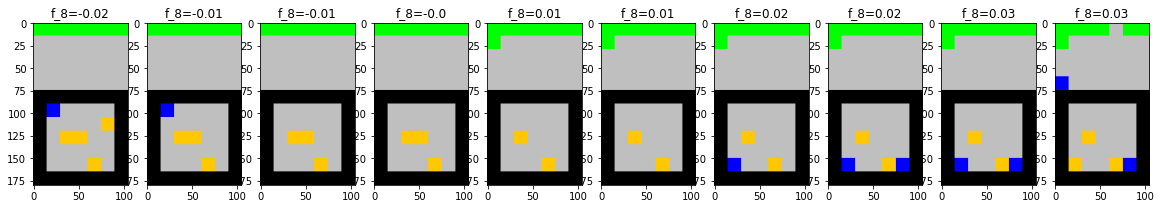

Feature 9, 10 steps


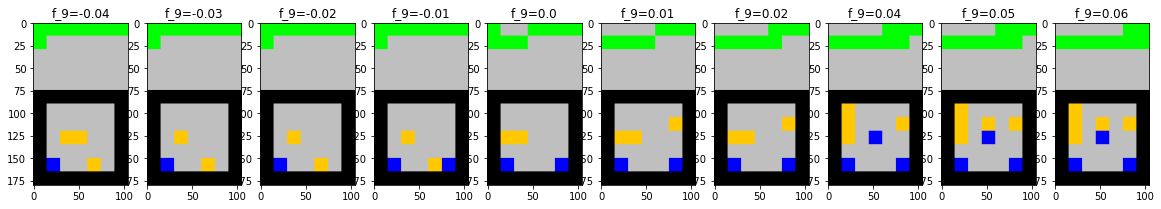

Feature 10, 10 steps


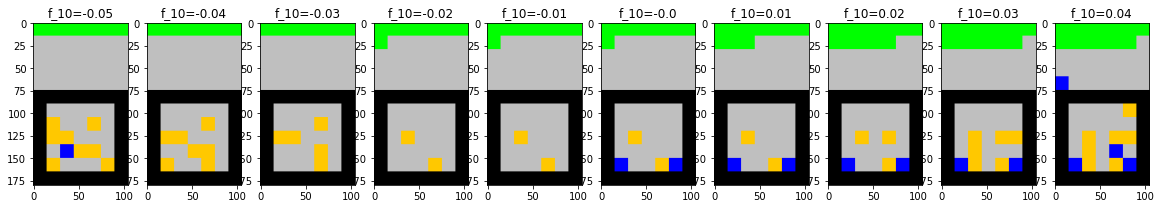

Feature 11, 10 steps


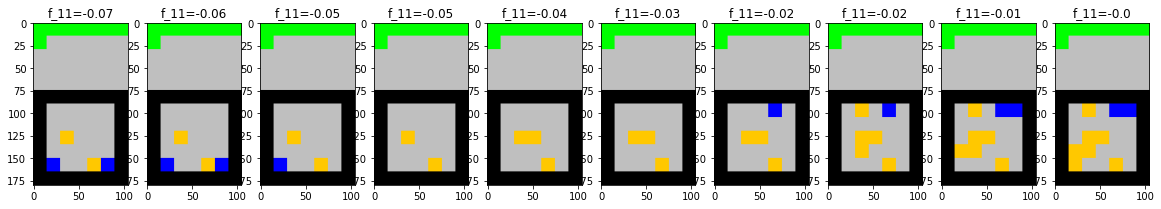

Feature 12, 10 steps


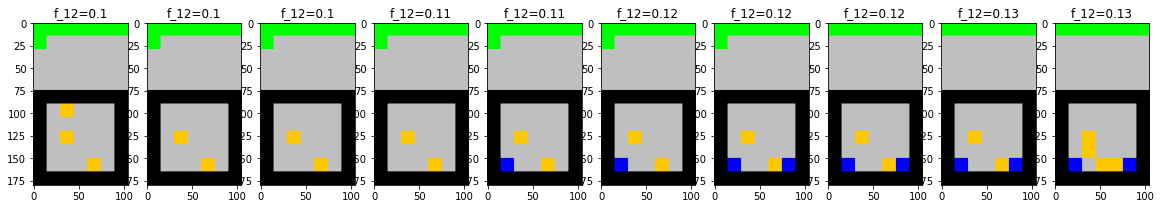

Feature 13, 10 steps


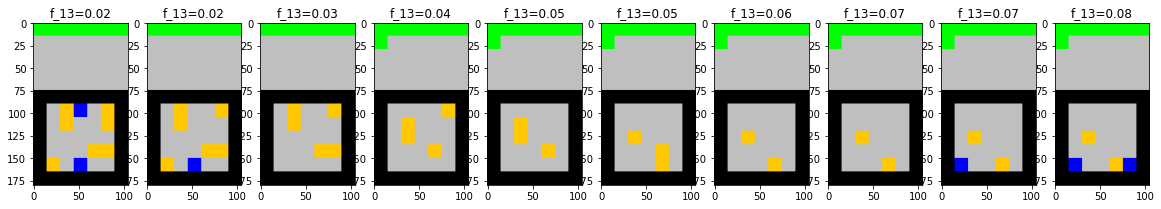

Feature 14, 10 steps


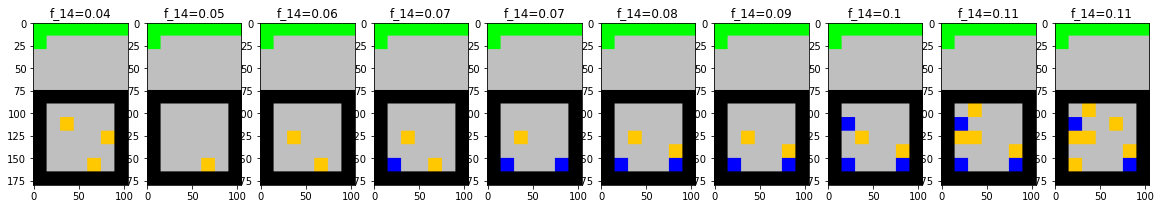

Feature 15, 10 steps


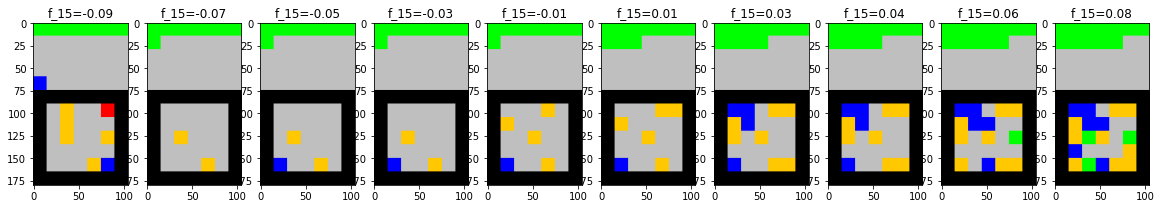

Feature 16, 10 steps


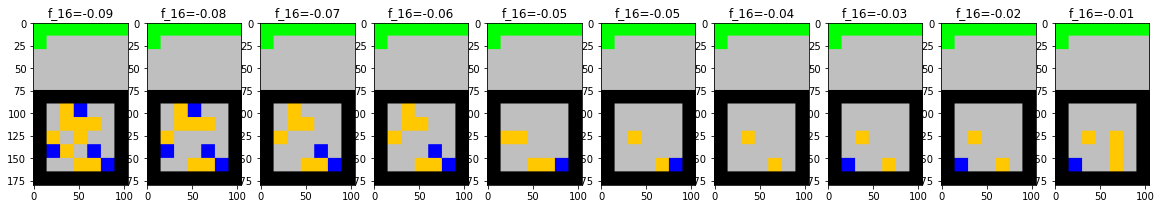

Feature 17, 10 steps


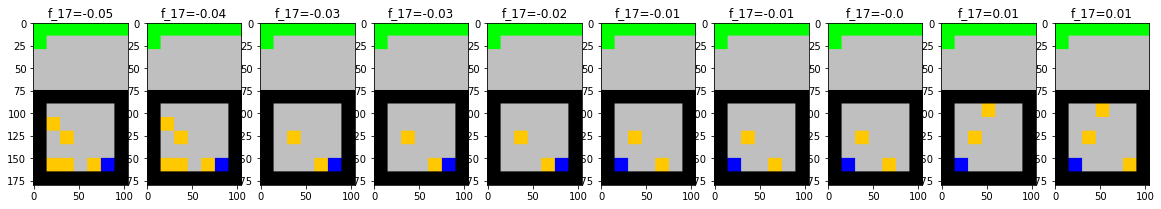

Feature 18, 10 steps


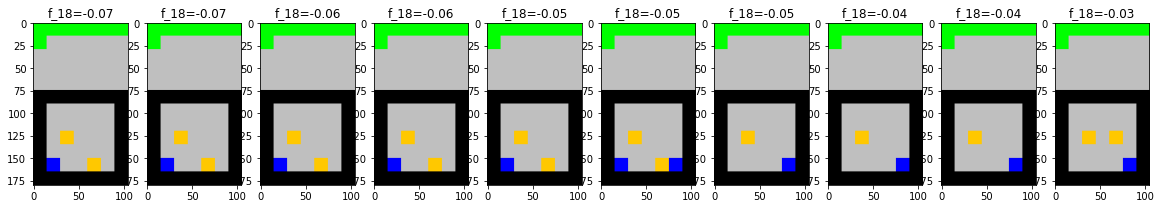

Feature 19, 10 steps


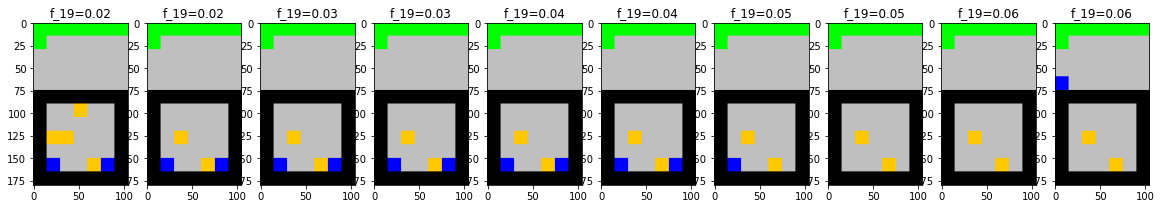

Feature 20, 10 steps


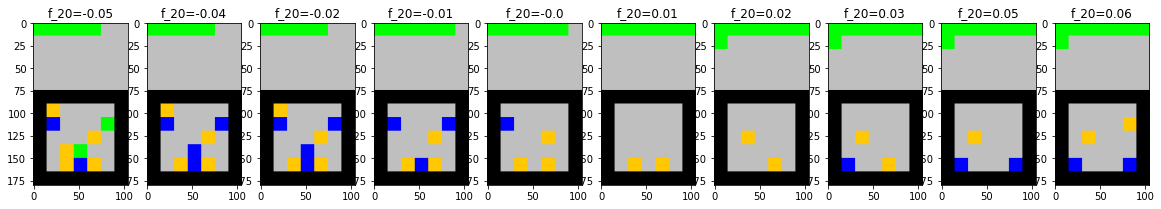

Feature 21, 10 steps


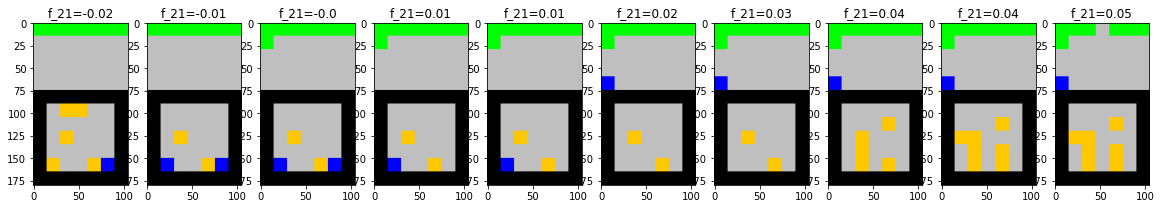

Feature 22, 10 steps


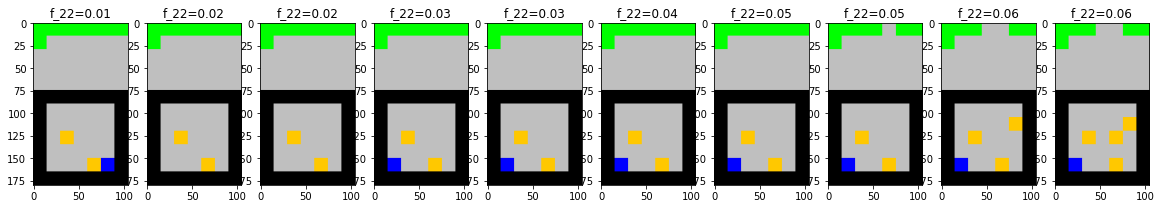

Feature 23, 10 steps


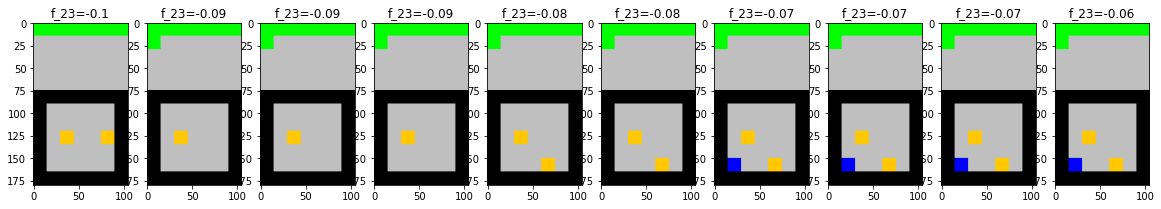

Feature 24, 10 steps


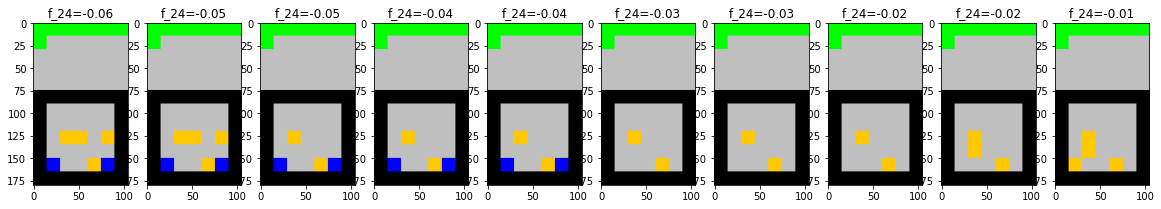

Feature 25, 10 steps


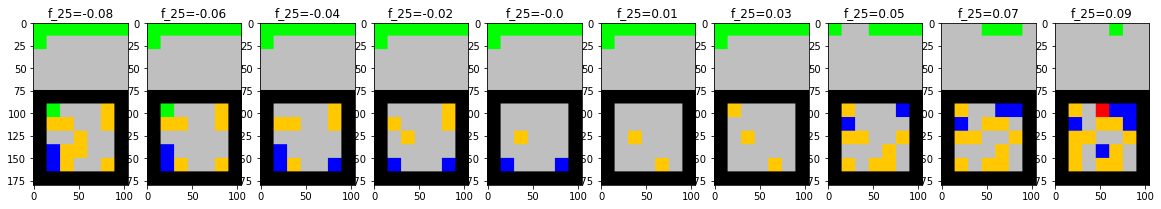

Feature 26, 10 steps


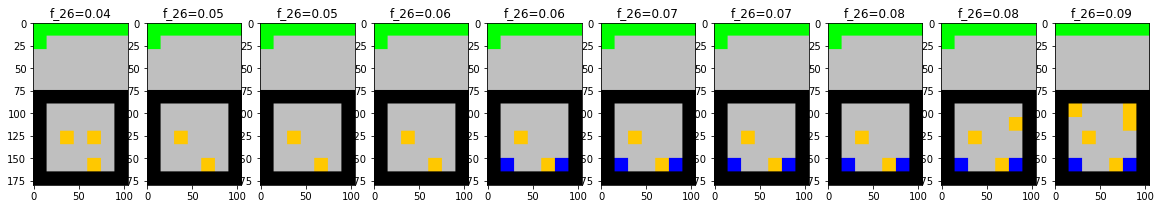

Feature 27, 10 steps


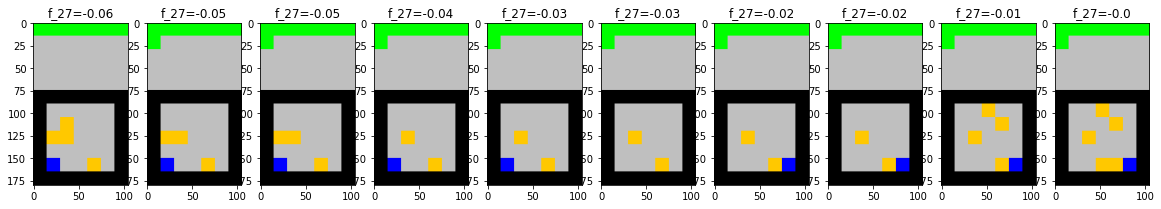

Feature 28, 10 steps


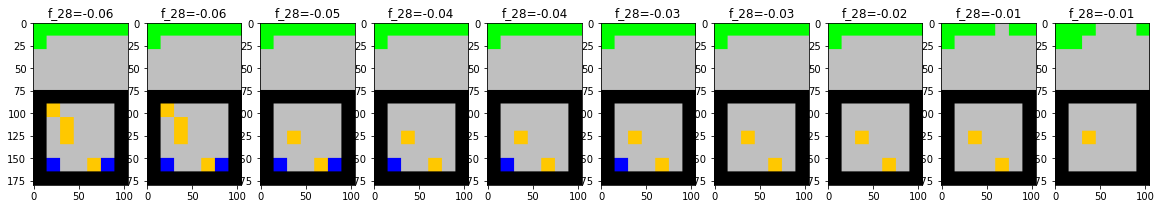

Feature 29, 10 steps


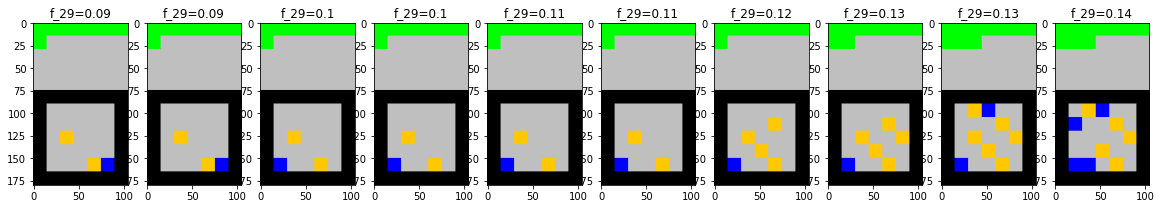

Feature 30, 10 steps


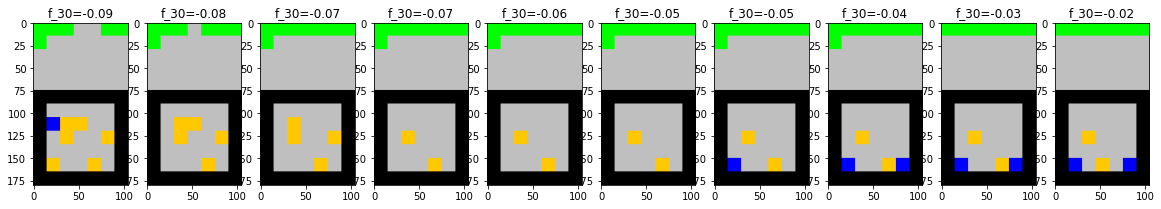

Feature 31, 10 steps


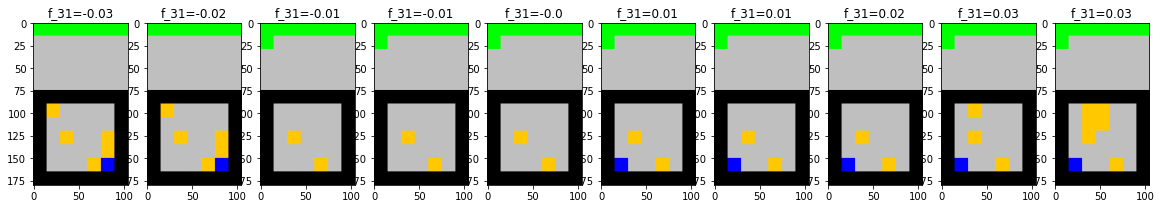

In [106]:
for f in range(n_latent):
    vis_feature(obs_model, latent_idx=f, n_steps=10)

#### Live demo for the encoder

In [107]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [108]:
kwargs = {"f%02d" % i: (latent_min_max[i][0], latent_min_max[i][1],
                        (latent_min_max[i][1] - latent_min_max[i][0]) / 10) for i in range(n_latent)}

In [110]:
@interact
def show_reconstructed(**kwargs):
    pass

interactive(children=(Output(),), _dom_classes=('widget-interact',))